# **Avant-Propos**

| Ce notebook a pour objectif d'expliquer le déroulement du projet et d'apporter une analyse sur notre méthodologie. Si vous souhaitez executer les différents processus par vous même, le repo du projet est disponible [ici](https://github.com/Tusked34/ML_Chess_2024), il est public et clonable.|
|-|

Ce repo contient :
- **Read Me** expliquant le projet, le contenue, l'organisation du repo, la manière de d'utiliser les fichiers pour reproduire/avancé le projet 
-  **Requirement**, nécéssaire pour mettre en place l'environnement python
- **Notebook explicatif**, que vous êtes entrain de lire actuellement
- **Fichiers Sources**, sous forme de fichiers python, un pour le traitement des données, un pour entrainer les modeles et un pour evaluer les modeles
- **Modeles** créers lors du projet
- **Données Utilisés**
- ...


**<span style="color:red">Attention : </span>** Nous conseillons d'executer le **traitement des données** et surtout **l'entrainement des modèles** sur une **machine adaptée aux calculs sur des grands volumes de données**. Ces processus peuvent prendre plusieurs heures, voirs plusieurs jours en fonction du volume de calcul utilisés.

# **Bibliothèques utilisées**

In [ ]:
import json

import pandas as pd
import numpy as np

import chess
import random

from Fct.fct_preprocess import *
from Fct.fct_eval import *

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Dense, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

---

# **<span style="color:#058C42">INTRODUCTION</span>**

A l'heure actuelle, le monde des **échecs professionnels** connaît une vraie **crise** :  

- Des parties de **tournois majeurs** pas retransmises en **direct live**,  
- Des scandales de **triches**,  
- **Magnus Carlsen** viré en plein **championnat du monde** pour être venu en **"tenue non-conforme"** (*un pantalon en jean*...).  

Ces incidents ont pour conséquence une **perte d'intérêt** du public pour la **FIDE** (*Fédération Internationale d'Échecs*) et pour le format de **partie longue**.  

Cependant, s'il y a bien une chose qui est sur une **bonne dynamique** dans les **échecs**, c'est bien l'**IA**. Cela fait bien des années que l'**intelligence artificielle** dépasse ce qui est **physiquement possible** à faire pour l'humain dans ce domaine.

Parmi tous les moteurs d'échecs ayant existé (**Deep-Blue, AlphaZero, Dragon**, etc...), le requin de cette catégorie, c'est <span style="color:green">**Stockfish**</span>.

<img src="https://raw.githubusercontent.com/Tusked34/ML_Chess_2024/refs/heads/main/Images/stockifsh_logo.png" alt="Logo Stockfish" width="350">  <img src="https://raw.githubusercontent.com/Tusked34/ML_Chess_2024/refs/heads/main/Images/chess_game_engige.png" alt="Chess game engige" width="600">

C'est un moteur d'échecs **open source** créé en 2008 par Tord Romstad, Marco Costalba et Joona Kiiski. Développé et amélioré par une communauté active, il est rapidement devenu l’un des moteurs d’échecs les plus puissants au monde. <span style="color:green">**Stockfish**</span> fonctionne en combinant des **algorithmes de recherche avancés**, comme l’élagage alpha-bêta et le Deep Iterative Deepening, avec une **fonction d’évaluation** capable d’analyser les positions selon divers critères : **avantage matériel**, **structure des pions**, **sécurité du roi**, etc. Depuis 2020, il intègre **NNUE**, un réseau de neurones optimisé pour les processeurs, qui améliore la précision de ses évaluations. Aujourd'hui, <span style="color:green">**Stockfish**</span> est utilisé pour analyser des parties, entraîner des joueurs, organiser des **tournois en ligne** et développer des projets d’intelligence artificielle. **Gratuit** et **open source**, il est devenu incontournable pour les amateurs et professionnels des échecs.

Pour en arrivé jusque la, **<span style="color:green">Stockfish</span>** s'appuie dans la combinaisons de multitude d'algorithmes, de technologies, méthodes analyses et entrainement depuis plus de 15 ans. Le "jeu des rois" étant devenue le "jeu des robots", nous allons faire de même. Notre objectif dans ce projet, est alors de créer une l'IA joueuse d'échecla plus performante possible, à l'aide un réseaux de neurone.

---

# **<span style="color:#058C42">1. CHOIX DU JEU DE DONNEES</span>**

Une des meilleure source donee en terme d'echec est **Lichess** (abréviation de "Libre Chess"), qui est une plateforme **gratuite** et **open-source** dédiée aux échecs en ligne. Elle permet aux joueurs de tous niveaux de jouer, apprendre et s'améliorer aux échecs via un accès navigateur web ou une application mobile. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Lichess_Logo_2019.svg/800px-Lichess_Logo_2019.svg.png" alt="Logo lichess" width="100">

Plusieurs **banques de données** sont disponibles en libre accès sur leur site internet, parmis elles, deux sont de bonnes candidates pour notre sujet :
- **Standars Chess** : Cette basse de donnée regroupe toutes les parties classées qui ont été joué sur lichess, chaque mois, depuis sa création, soit 6 298 645 464 parties standard.
- **Evaluation"** : 173 866 932 positions d'échecs différentes évaluées avec Stockfish. Produites par et pour le tableau d'analyse de Lichess, utilisant différentes versions de Stockfish dans les navigateurs des utilisateurs. Cette banque de donnée est dédié à la recherche.

BLABLABLA a completer et reecrire en ajoutant parargraphe sur l'IA : Grace a notre reflexion personnelle et a l'avis de ChatGPT, nous avons vue que le choix de prendre les données "Evaluation" est notre meilleur choix : 
stockifsh est + fort que nimporte quel joueur donc meilleurs données + même parmis toutes les parties il faut prendre celles avec les top joueurs et même eux peuvent faire de la merde parfois donc pas 100 fiables. Stockfish que des positions différentes et plusieurs evaluations différentes pour chacune donc c'est hyper pertinent pas de données a jeter.

Même si cela revient a utiliser une IA pour entrainer notre IA, Stockfish lui même s'appuyer sur le moteur "Glaurung", il vaut mieux mettre toute les chances de notre coté et prendre les meilleurs données a notre dispositon.

Le fichier brut faisant 40 giga, n'est uploadable sur le git, mais il est dispnible en telechargement libre a l'adresse suivante : https://database.lichess.org/#evals 
Si vous souhaitez reproduire le traitement des données et l'entrainement des modèles via les fichiers du dossier **src**, il faut telecharger le fichier ci-dessus de le placer dans le dossier **data** sous le nom **"lichess_db_eval.jsonl"**

*NB : les données de ce fichier varies légérements au file du temps car il est mis a jours tout les 1er du mois par Lichess. Celui que nous utilisons date du 1er decembre 2024.*

---

# **<span style="color:#058C42">2. EXPLORATION ET TRAITEMENT DES DONNEES</span>**

## **<span style="color:#8DA990">2.A. Definition des Fonctions</span>**

In [ ]:
def extract_data(file_path, max_rows=1000000):
    """
    Extrait les données d'un fichier JSONL contenant des positions d'échecs et les évalue, 
    en créant un DataFrame à partir des informations extraites.

    Args:
        file_path (str): Chemin du fichier contenant les données au format JSONL (une position par ligne).
        max_rows (int, optional): Nombre maximal de lignes à lire dans le fichier. Par défaut, 1 000 000.

    Returns:
        pandas.DataFrame: Un DataFrame contenant les colonnes suivantes :
            - "fen" : Représentation FEN de l'échiquier.
            - "knodes" : Nombre de nœuds évalués.
            - "depth" : Profondeur de recherche de l'évaluation.
            - "cp" : Centipawn score de l'évaluation (avantage positionnel en valeurs de pions).
            - "mate" : Nombre de coups avant échec et mat (si applicable).
            - "line" : Ligne de coups prévus.
    """
    data = []  # Liste pour stocker les données extraites
    
    # Ouvre le fichier en lecture
    with open(file_path, 'r') as f:
        for idx, line in enumerate(f):
            # Arrête la lecture si le nombre maximal de lignes est atteint
            if idx >= max_rows:
                break

            # Chargement de la ligne JSON en dictionnaire Python
            position = json.loads(line)
            fen = position.get("fen")  # Extrait le code FEN
            
            # Parcoure les évaluations disponibles pour cette position
            for eval_data in position.get("evals", []):
                knodes = eval_data.get("knodes")  # Nombre de nœuds évalués
                depth = eval_data.get("depth")   # Profondeur de recherche
                
                # Parcoure les variantes principales (principal variations)
                for pv in eval_data.get("pvs", []):
                    cp = pv.get("cp")       # Score centipawn
                    mate = pv.get("mate")   # Nombre de coups avant mat (si applicable)
                    line = pv.get("line")   # Ligne de coups prévus
                    
                    # Ajoute les données extraites à la liste
                    data.append({
                        "fen": fen,
                        "knodes": knodes,
                        "depth": depth,
                        "cp": cp,
                        "mate": mate,
                        "line": line
                    })

    # Convertion de la liste de dictionnaires en DataFrame pandas
    return pd.DataFrame(data)

In [ ]:
def extract_next_move(df):
    """
    Extrait le premier coup de la colonne 'line' et le stocke dans 'best_move_m1'.
    """
    df["best_move_m1"] = df["line"].str.extract(r'(\S+)', expand=False)
    return df

In [ ]:
def most_popular_predict_V1(df):
    """
    Ajoute la colonne 'best_move_m2' avec le coup le plus fréquent pour chaque position FEN.
    """
    most_popular_moves = (
        df.groupby('fen')['best_move_m1']
        .agg(lambda x: x.value_counts().idxmax())  # Coup le plus fréquent par groupe FEN
        .rename("best_move_m2"))
    
    df = df.merge(most_popular_moves, on='fen', how='left')
    return df

In [ ]:
def filter_best_predict(df):
    """
    Filtre les meilleures évaluations par position FEN, en priorisant la profondeur maximale et les évaluations de mat.
    """
    filtered_rows = []

    # Grouper par position FEN
    for fen, group in df.groupby('fen'):
        # Étape 1 : Sélectionner les évaluations avec la profondeur maximale
        max_depth = group['depth'].max()
        best_evals = group[group['depth'] == max_depth]
        
        # Étape 2 : Priorité à une évaluation de mat si elle existe
        if 'mate' in best_evals and best_evals['mate'].notna().any():
            best_row = best_evals.loc[best_evals['mate'].idxmin()]
        else:
            # Sinon, maximiser la valeur `cp`
            best_row = best_evals.loc[best_evals['cp'].idxmax()]
        
        # Ajouter la meilleure évaluation à la liste
        filtered_rows.append(best_row)
    
    # Créer un nouveau DataFrame avec les meilleures évaluations
    return pd.DataFrame(filtered_rows).reset_index(drop=True)

In [ ]:
def drop_usuless_columns(df) :
    """
    Supprime les colonnes inutiles du DataFrame.
    """
    df = df.drop(columns=['line','mate','cp','depth','knodes'])
    return df

## **<span style="color:#8DA990">2.B. Extraction des données</span>**

Le fichier **JSONL** contenant les données originales comprend **170 millions de positions différentes**, chacune avec plusieurs **évaluations Stockfish**.  

**<span style="color:#F5464C; text-decoration: underline;">Attention :</span>** la taille des données a un impact direct sur les performances et le temps de traitement, un facteur clé pour l'optimisation du processus.

Nous limitons alors la taille de notre futur jeu de données en deux fichiers :  
- **Le premier**, plus petit, contient **1 million de positions**.  
- **Le second**, plus grand, contient **10 millions de positions**.  

Cette limitation permet de **réduire le temps d'entraînement** de nos modèles, ce dernier étant **proportionnel** à la taille des données d'entraînement.  



In [8]:
file_path = 'data\lichess_db_eval.jsonl'
max_rows = 10000000

data_raw = extract_data(file_path, max_rows)
data_raw.head(5)

,fen,knodes,depth,cp,mate,line
0,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,200973,39,58.0,NaN,f7g7 e6e2 h8d8 e2d2 b7b5 c4e6 g7f6 e6b3 a6a5 a2a3
1,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,71927,32,62.0,NaN,f7g7 e6e2 b7b5 c4b3 h8d8 e2d2 a6a5 a2a3 g7f6 d1e1
2,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,71927,32,151.0,NaN,h8d8 d1e1 a6a5 a2a3 b7b5 c4a2 c6d7 e6e7 f7g6 e1f2
3,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,59730,31,64.0,NaN,f7g7 e6e2 g7g6 d1c2 h8d8 e2d2 g6f6 a2a3 b7b5 c4a2
4,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,59730,31,134.0,NaN,h8d8 d1e1 a6a5 a2a3 b7b5 c4b3 a5a4 b3a2 c6d7 e6h6


Après extraction nous nous retrouvons avec un dataframe où chaque ligne represente une evaluation d'une certaine poistion, ainsi que **5 variables** associés : 

| Variable            | Description                                                                                                        |
|-----------------|--------------------------------------------------------------------------------------------------------------------|
| **FEN**      | Le FEN (pour Forsyth-Edwards Notation) est une méthode standard utilisée en échecs pour représenter une position spécifique sur l'échiquier.               |
| **knodes**      | Nombre de milliers de nœuds analysés par stockfish pendant la recherche de la position.                   |
| **depth**       | Profondeur de la recherche, indiquant le nombre de coups (ou niveaux) explorés par le moteur.                     |
| **cp**          | Évaluation en centipions, représentant un avantage matériel en fonction du côté actif (positif pour Blancs, négatif pour Noirs). |
| **mate**        | Évaluation de mat. Si une valeur est donnée, elle indique le nombre de coups restants avant que le mat soit atteint. |
| **line**        | Ligne (parfois appelée variante) désigne une séquence de coups qui découle d'une position donnée. Elle représente une possible continuation du jeu |

## **<span style="color:#8DA990">2.C. Nettoyage des données </span>** 

 **<span style="color:green">Stockfish</span>** utilise différents parametre dans ses algorythmes, notamment le **nombre de noeuf (knodes)** et le la **profondeur (depth)**. En fonction de ces différents parametres, stockfish calcul le **centipions (cp)** et **l'évaluation du mate (mate)**.  

Après ces évaluations, il peut alors parfois prédire des coups différents pour une même position, on appelle cela des **variantes**. Certains joueurs vont être plus a l'aise dans une variante plûtot qu'une autre en fonction de leurs styles de jeu, mais pour notre IA cela n'as pas d'importance. Il est alors plus opportun pour notre jeu de donnée de ne garder

Nous pouvons alors utiliser 2 méthodes pour garder la meilleur variante.

**`Méthode N°1 : Analyse des Parametres et de l'Evaluation`**

Cette méthode va permettre de choisir la meilleur evaluation selon des critères hiarrachisés par ordre d'importance

   1. **Profondeur de recherche (depth)** : Plus la profondeur est grande, plus l'analyse est précise. Priorisations des évaluations avec la profondeur maximale.

   2. **Centipions (cp) ou mat (mate)** : Si une évaluation donne un **mate**, elle est prioritaire, car un mat forcé est absolu. En absence de **mate**, choix d'évaluation avec la valeur **cp** la plus élevée pour le joueur actif

   3. **Nombre de nœuds analysés (knodes)** : Si plusieurs évaluations ont la même profondeur, celle ayant exploré le plus grand nombre de nœuds est théoriquement plus fiable.

   4. **En cas d'égalité parfaite**: En cas d’égalité sur les autres critères, utilisez une évaluation arbitraire.`

**`Méthode N°2 : Coup le Plus Populaire`**

Cette méthode conciste simplement a prendre le coup le plus récurrent parmis ceux proposer par les évaluations pour une même position`


- **Création d'une variable `best_move_m1`, qui extrait uniquement, prochain coup a jouer, c'est a dire le premier coup de la ligne.**

In [9]:
data_V1 = extract_next_move(data_raw)
data_V1.head(3)

,fen,knodes,depth,cp,mate,line,best_move_m1
0,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,200973,39,58.0,NaN,f7g7 e6e2 h8d8 e2d2 b7b5 c4e6 g7f6 e6b3 a6a5 a2a3,f7g7
1,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,71927,32,62.0,NaN,f7g7 e6e2 b7b5 c4b3 h8d8 e2d2 a6a5 a2a3 g7f6 d1e1,f7g7
2,7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -,71927,32,151.0,NaN,h8d8 d1e1 a6a5 a2a3 b7b5 c4a2 c6d7 e6e7 f7g6 e1f2,h8d8


- **Création d'une variable `best_move_m2` avec le coup le plus populaire par position en suivant la Méthode N°2 et `best_move_m1` selon la Méthode N°1.** 

Par conséquent chaque ligne represente des positions différentes)

In [11]:
data_V2 = most_popular_predict_V1(data_V1)
data_V3 = filter_best_predict(data_V2)
data_V3.head(3)

,fen,knodes,depth,cp,mate,line,best_move_m1,best_move_m2
0,1K6/1P4p1/2n4k/p6p/8/8/8/8 w - -,159161,29,NaN,-12.0,b8a8 a5a4 b7b8b c6b8 a8b8 a4a3 b8c8 a3a2 c8d7 ...,b8a8,b8c8
1,1K6/1P4p1/7k/p3n2p/8/8/8/8 b - -,186187,25,460.0,NaN,e5c6 b8c7 c6b4 c7b6 b4d5 b6c6 d5b4 c6b5 h6g5 b...,e5c6,e5c6
2,1K6/2Pk4/b7/5ppp/8/p5P1/4PP1P/B7 w - -,1472,39,0.0,NaN,e2e3 a3a2 a1c3 a6c8 f2f3 g5g4 f3g4 h5g4 c3d4 c8a6,e2e3,e2e3


- **Suppression des variables inutiles.**

Les variables `knodes`, `depth`, `cp`, `mate` et `line` qui était utiles pour trouver le meilleur coup selon la méthode 1 mais deviennt obseletes pour la suite du projet

In [12]:
data_cleaned = drop_usuless_columns(data_V3)
data_cleaned.head(5)

,fen,best_move_m1,best_move_m2
0,1K6/1P4p1/2n4k/p6p/8/8/8/8 w - -,b8a8,b8c8
1,1K6/1P4p1/7k/p3n2p/8/8/8/8 b - -,e5c6,e5c6
2,1K6/2Pk4/b7/5ppp/8/p5P1/4PP1P/B7 w - -,e2e3,e2e3
3,1Kb2n2/2P1k3/2B5/4Bppp/8/p5P1/4PP1P/8 b - -,f8d7,c8e6
4,1Kb5/2PBk3/8/4Bppp/8/p5P1/4PP1P/8 b - -,c8d7,e7d7


- **Sauvegarde des données netoyées en CSV**

In [13]:
data_cleaned.to_csv('data/data_cleaned.csv')

---

# **<span style="color:#058C42">3. MODELISATION</span>**

## **<span style="color:#8DA990">3.A. Definition des fonctions </span>**

In [ ]:
def fen_to_matrix(fen: str):
    """
    Convertit une position d'échecs en FEN en une matrice 8x8x13.
    8*8 pour les cases de l'échequier et *13 pour chaque pieces uniques (6 Blanches et 6 Noires) + 1 dimension representant les cases où il est possible de jouer un coup légal.
    
    Parameters: 
        La représentation FEN de la position.
    
    Returns:
        Une matrice numpy 8x8x13 représentant la position.
    """
    board = chess.Board(fen) #  convertit une représentation FEN en un objet manipulable qui contient toutes les informations sur la position d'échecs. Cet objet permet ensuite de travailler directement avec l'échiquier dans le code.
    matrix = np.zeros((13, 8, 8))
    piece_map = board.piece_map()

    # Populate first 12 8x8 boards (where pieces are)
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        piece_type = piece.piece_type - 1
        piece_color = 0 if piece.color else 6
        matrix[piece_type + piece_color, row, col] = 1

    # Populate the legal moves board (13th 8x8 board)
    legal_moves = board.legal_moves
    for move in legal_moves:
        to_square = move.to_square
        row_to, col_to = divmod(to_square, 8)
        matrix[12, row_to, col_to] = 1

    return matrix

In [ ]:
def encode_moves(moves):
    """
        Cette fonction prend une liste de coups d'échecs (sous forme de chaînes) et encode chaque coup unique
        sous forme d'un entier unique. Elle retourne également un dictionnaire qui associe chaque coup à son
        entier correspondant.
    """
    move_to_int = {move: idx for idx, move in enumerate(set(moves))}
    return [move_to_int[move] for move in moves], move_to_int

## **<span style="color:#8DA990">3.B. Transformation finale des données</span>**

Nous avons notre disposition la variable cible, qui est le meilleur coup jouable et la position qui y est associé (sous forme de texte FEN). Cependant il reste une dernière étape avant de créer notre modèle de réseau de neurones. En effet nos données ne sont pas totalement pretes a l'usage, les reseaux de neurones que nous allons mettre en place ne peuvent pas comprendre directement le FEN sous forme de texte, il faut alors le modifier sous un format addapté, par exemple une matrice numpy.

In [2]:
data = pd.read_csv('data/data_cleaned.csv' )

X = data['fen']
y = data['best_move_m1']

Traduction des données sous une forme interpretable par le reseau de neurone.
  - **Position (Fen)** -> Matrice Numpy 8x8x13
    - 8*8 pour representer les cases de l'échequier
    - *12 chaque pieces uniques (6 Blanches et 6 Noires)
    - +1 dimension en 8*8 representant les cases où il est possible de jouer un coup légal

<img src="https://raw.githubusercontent.com/Tusked34/ML_Chess_2024/refs/heads/main/Images/Matrice_Chess.png" alt="Chess game engige" width="600">

  - **Coup a joué (UCI)** -> Encodage de chaque coup distincts (sous forme d'entier) dans un dictionnaire\
  *exemple :  "e2e4":1 , "e2e3"=2, etc...*


In [ ]:
X = X.apply(fen_to_matrix)
X = np.array(X.tolist())

y, move_to_int = encode_moves(y)
y = to_categorical(y, num_classes=len(move_to_int))

# Sauvegarde de move_to_int dans un fichier JSON
with open('Models/move_int_dico.json', 'w') as file:
    json.dump(move_to_int, file)

## **<span style="color:#8DA990">3.C. Spécification des Modèles</span>**

A FINIR!!!!!!!!!! Dire qu'on a fait un modele de base, puis on a demandé de l'aide a chatgpt pour améliorer le modèle avec l'aide de chatgpt

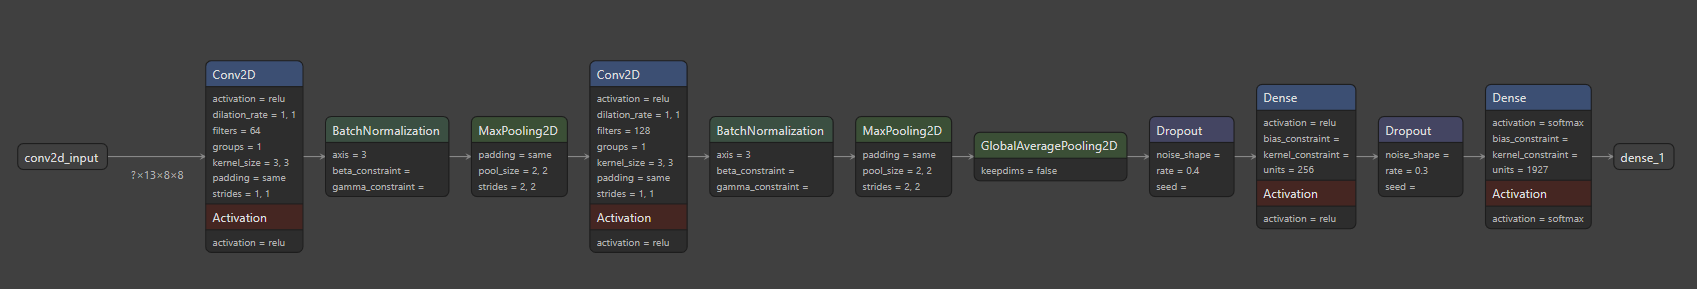

- **Première couche de convolution :** 
    - *Conv2D(64, (3, 3), activation='relu', input_shape=(13, 8, 8)) :* 
        - **64** : nombre de filtres (ou noyaux de convolution) utilisés par la couche. 
        - **(3, 3)** : taille des filtres (matrice 3x3 pour détecter des caractéristiques locales). 
        - **activation='relu'** : fonction d'activation ReLU (Rectified Linear Unit) qui introduit de la non-linéarité. 
        - **input_shape=(13, 8, 8)** : forme de l'entrée (par exemple, un tenseur 13x8x8 représentant vos données d'entrée). 
    - *BatchNormalization():* 
        - Normalisation des données en entrée de la couche suivante pour stabiliser et accélérer l'apprentissage.
    - *MaxPooling2D(pool_size=(2, 2)):*  
        - Sous-échantillonnage spatial (réduction de la dimension spatiale).
        - **pool_size=(2, 2)** : taille de la fenêtre de pooling (matrice 2x2) qui réduit chaque dimension de moitié.
        
- **Deuxième couche de convolution :** 
    - *Conv2D(128, (3, 3), activation='relu') :* 
        - **128** : nombre de filtres plus élevé pour apprendre des caractéristiques plus complexes.
        - **(3, 3)** : taille des filtres.
        - **activation='relu'** : même fonction d'activation pour conserver la non-linéarité.
    - *BatchNormalization():* 
        - Normalisation des données en entrée de la couche suivante pour stabiliser et accélérer l'apprentissage.
    - *MaxPooling2D(pool_size=(2, 2)):*  
        - Sous-échantillonnage spatial (réduction de la dimension spatiale).
        - **pool_size=(2, 2)** : taille de la fenêtre de pooling (matrice 2x2) qui réduit chaque dimension de moitié.

- **Suite des paramètres :** 
    -  *Flatten() :* 
        - Mise à plat des données (passage des données 2D/3D à un vecteur 1D) pour préparer les données pour les couches denses.
    - *Dropout(0.4) :* 
        - Régularisation pour réduire le surapprentissage.
        - **0.4** : 40% des neurones sont désactivés pendant l'entraînement.

    - *Dense(256, activation='relu') :* 
        - Couche entièrement connectée (dense).
        - **256** : nombre de neurones dans la couche.
        - **activation='relu'** : fonction d'activation ReLU pour apprendre des représentations complexes.

    - *Dropout(0.3) :* 
        - Dropout supplémentaire, mais avec un taux réduit (30%) pour limiter encore le surapprentissage tout en maintenant les performances.

    - *Dense(len(move_to_int), activation='softmax') :* 
        - Couche de sortie entièrement connectée.
        - **len(move_to_int)** : nombre de classes possibles dans la tâche de classification (dimension de sortie).
        - **activation='softmax'** : fonction d'activation Softmax pour produire des probabilités normalisées pour chaque classe.

#### **Justifications des spécifications du modèle :**

-   *1. Entrée du modèle : input_shape=(13, 8, 8) :* 
    -   La dimension **(13, 8, 8)** est cohérente avec une représentation d'un échiquier : \
        **8x8** représente les cases de l'échiquier. \
        **13** couches (ou canaux) permettent de coder les différentes informations nécessaires : \
        Positions des pièces blanches et noires (par exemple, une couche par type de pièce). 
    -   Informations supplémentaires comme le droit de roquer, la possibilité d'une prise en passant, etc. \
        Cette structuration est standard pour les réseaux convolutifs, car elle tire parti des propriétés spatiales des données. 

    -   Améliorations possibles : \
        Ajouter plus de dimensions pertinentes si nécessaire, comme un historique des coups pour aider à prédire les intentions stratégiques.

-   *2. Couche de convolution : Conv2D :*
    -   Les couches convolutives sont bien adaptées pour : \
        Identifier des motifs locaux, comme des alignements de pièces ou des attaques potentielles.\
        Exploiter la structure spatiale de l'échiquier.

    -   Paramètres des couches convolutives : \
        **64** filtres (1ère couche) et **128** filtres (2ème couche) : \
        Permettent d'extraire des motifs simples dans les premières couches (par exemple, relations entre deux pièces) et des motifs plus complexes dans les couches profondes (comme des schémas stratégiques sur une partie de l'échiquier). 
    -   Taille des filtres (3, 3) : \
        Taille standard pour détecter des relations entre pièces sur des zones locales de l'échiquier. \
        Peut être adapté pour capturer plus de contexte (par exemple, (5, 5) pourrait identifier des structures plus globales comme un réseau de défense).

-   *3. Batch Normalization :* 
    - Stabilise l'entraînement du réseau et permet des mises à jour de poids plus efficaces. \
    Crucial pour des architectures profondes où des déséquilibres d'échelle dans les activations pourraient ralentir l'apprentissage.

-   *4. MaxPooling2D :*
    -   Utilité : \
    Réduit les dimensions spatiales, ce qui permet de capturer des relations globales en résumant des zones locales de l'échiquier.
    Le pooling successif peut, cependant, entraîner une perte de précision sur les positions exactes des pièces.

    - Limites potentielles : \
    Les échecs nécessitent souvent une localisation précise des pièces (un cavalier ou une reine mal positionné peut changer complètement le sens d'un coup).\
    L’utilisation de techniques comme strided convolutions ou une réduction de la profondeur de pooling pourrait éviter cette perte de précision.

-   *5. Flatten :*
    - Après les couches convolutives, les données 2D (spatiales) sont aplaties en un vecteur 1D pour permettre des connexions avec les couches entièrement connectées. 
    - Cela combine toutes les caractéristiques extraites par les convolutions en un ensemble global.

-   *6. Dropout :*
    - Évite le surapprentissage, ce qui est crucial pour généraliser sur des positions d'échiquier variées et imprévues. \
    Les taux de **0.4** (40%) et **0.3** (30%) sont raisonnables : \
    Éviter de surcharger le modèle tout en maintenant une capacité suffisante pour apprendre des motifs complexes.

    - Limites : \
    Pour une IA jouant aux échecs, une approche comme l'entraînement régularisé combiné à des données augmentées (positions générées à partir de parties réelles ou simulées) pourrait être encore plus efficace.

-   *7. Dense Layers :*
    - **256** neurones (1ère couche dense) : \
    Permet d'apprendre des représentations abstraites globales du plateau après les convolutions.\
    Bon compromis entre la capacité d'apprentissage et la régularisation.\
    Couche de sortie : Dense(len(move_to_int), activation='softmax')

    - len(move_to_int) : \
    Correspond au nombre total de coups possibles dans une position d'échecs. Cela inclut les coups valides et les promotions.

    - Activation softmax : \
    Transforme les scores en probabilités normalisées. \
    Utile pour choisir le coup avec la plus forte probabilité comme sortie.

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(13, 8, 8)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.4),  
    Dense(256, activation='relu'),
    Dropout(0.3),  
    Dense(len(move_to_int), activation='softmax')
])

## **<span style="color:#8DA990">3.D. Spécification du Compilateur</span>**

#### Compilation du modèle avec un optimiseur personnalisé, une fonction de perte et des métriques.

- *model_2.compile(optimizer=Adam(learning_rate=1e-4) :*  
    - Optimiseur utilisé pour ajuster les poids du modèle.
    - **Adam** : un optimiseur efficace combinant les avantages d'Adagrad et RMSProp.
    - **learning_rate=1e-4** : taux d'apprentissage (0.0001) contrôle la vitesse à laquelle l'optimiseur ajuste les poids.
    - Un learning rate bas favorise un apprentissage stable mais peut être plus lent.
- *loss='categorical_crossentropy' :*
    - Fonction de perte utilisée pour mesurer l'écart entre les prédictions du modèle et les véritables étiquettes.
    - **'categorical_crossentropy'** : utilisée pour des problèmes de classification multi-classe où les étiquettes sont représentées sous forme one-hot.
- *metrics=['accuracy'] :*
    - Liste des métriques à suivre pendant l'entraînement et l'évaluation.
    - **'accuracy'** : proportion de prédictions correctes, utile pour évaluer les performances globales du modèle.
)


#### Justification de l'utilisation de la fonction de compilation

Cette fonction de compilation sert à configurer les aspects fondamentaux de l’entraînement du modèle dans le cadre de la création d’une IA jouant aux échecs de manière avancée. Voici un décryptage de ses éléments dans ce contexte particulier :

-   *1. Optimiseur : Adam(learning_rate=1e-4):*

    - Rôle dans une IA d'échecs : \
    Ajuste les poids du modèle pour minimiser la perte pendant l’entraînement.
    
    - Pourquoi Adam ? \
    Adam combine les avantages de RMSProp (adapte dynamiquement le taux d'apprentissage pour chaque poids) et momentum (accélère l'apprentissage en zones de faible gradient). \
    Convient aux architectures complexes comme celles utilisées ici, en garantissant une convergence rapide et efficace.

    - Pourquoi un learning rate de 1e-4 ? \
    Aux échecs, les motifs et stratégies peuvent être complexes et subtils. \
    Un learning rate bas (0.0001) permet un ajustement progressif, réduisant le risque de sauter des minima locaux ou d'osciller autour d’une solution optimale.\
    Ce choix est crucial pour capturer des relations stratégiques délicates, comme les sacrifices ou les plans à long terme.

-   *2. Fonction de perte : categorical_crossentropy:*
    -   Rôle dans une IA d'échecs : \
    Mesure la différence entre les prédictions du modèle et la vérité terrain.

    - Pourquoi categorical_crossentropy ? \
    Les échecs sont un problème de classification multi-classe : pour chaque position donnée, le modèle doit prédire un coup parmi un ensemble de coups possibles. \
    Les étiquettes (coups possibles) sont souvent représentées sous forme one-hot : 
        - Exemple : Si un coup spécifique est correct, sa probabilité dans le vecteur de sortie est 1, et les autres sont 0. \
        La perte categorical_crossentropy punit les prédictions qui s’écartent de la probabilité correcte, forçant le modèle à se concentrer sur les coups les plus plausibles.

-   *3. Métrique : accuracy :*
    - Rôle dans une IA d'échecs : \
    Suit la proportion de coups prédits correctement.

    - Pourquoi utiliser l'accuracy ? \
    Permet de mesurer si le modèle est capable de reproduire les coups attendus pour des positions données, comme dans des parties annotées ou simulées. \
    Cela donne une indication globale des performances du modèle pendant l’entraînement.

    - Limitation de l’accuracy : \
    Aux échecs, il peut y avoir plusieurs coups corrects dans une position donnée (par exemple, coups équivalents ou différents plans stratégiques). \
    Une simple mesure d’accuracy ne capture pas toujours cette diversité.


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',  
    metrics=['accuracy']  
)

## **<span style="color:#8DA990">3.E. Entrainement</span>**

Il y a une infinité de paramétrage possible sur un modele de reseau de neurones. Nous avons fait le choix de rester sur les meme specs pour chaque modele. Cependant, nous allons faire varier le nombre d'epoch et le volume d'entrainement.

### **Modèle N°2**

- SUR 1M de data avec 25 epoch

In [ ]:

model.fit(X, y, epochs=25, validation_split=0.1, batch_size=64)

### **Modèle N°3** :

Même modele mais avec 10M au lieu d'1M de data

In [ ]:
model.fit(X, y, epochs=50, validation_split=0.1, batch_size=128)

### **Modèle N°4** :

Même Modele mais avec 10M et 85 EPOCH

In [ ]:
model.fit(X, y, epochs=85, validation_split=0.1, batch_size=128)

---

# **<span style="color:#058C42">4. EVALUATION</span>**

## **<span style="color:#8DA990">4.A. Definition des fonctions </span>**

In [ ]:
def predict_next_move(board, model, move_int_dico):
    """
    Prédit les prochains coups dans une partie d'échecs en fonction de l'état actuel de l'échiquier et de du modèle selectionné.

    Args:
        board (chess.Board): L'échiquier actuel représenté en utilisant la bibliothèque python-chess.
        model (tensorflow.keras.Model): Le modèle d'apprentissage automatique utilisé pour prédire les mouvements.
        move_int_dico (dict): Un dictionnaire qui associe les indices des mouvements aux notations de coups.

    Returns:
        list: Une liste de coups prévus triés par ordre décroissant de probabilité.
    """
    # Obtient la représentation FEN de l'échiquier et le convertir en une matrice adaptée à l'entrée du modèle
    fen_code = board.fen()
    board_matrix = fen_to_matrix(fen_code)
    board_matrix = np.expand_dims(board_matrix, axis=0) # Ajoute une dimension supplémentaire à la matrice (batch size) pour correspondre au format attendu par le modèle
    predictions = model.predict(board_matrix)[0]  # Effectue une prédiction à l'aide du modèle
    sorted_indices = np.argsort(predictions)[::-1]  # Trie les indices des coups prévus par probabilité décroissante
    predicted_moves_sorted = [move_int_dico[idx] for idx in sorted_indices] # Traduit la liste des predictions en coup d'échec
    
    return predicted_moves_sorted

In [ ]:
def predict_legal_next_move(board, predicted_moves_sorted):
    """
    Sélectionne le premier coup légal parmi une liste de coups prévus pour un échiquier donné.

    Args:
        board (chess.Board): L'échiquier actuel représenté en utilisant la bibliothèque python-chess.
        predicted_moves_sorted (list): Une liste de coups prévus (notation UCI), triés par probabilité décroissante.

    Returns:
        str or None: Le premier coup légal trouvé sous forme de chaîne (notation UCI),
                     ou None si aucun des coups prédits n'est légal.
    """
    # Parcour les coups prédits et vérifie si le coup est légal dans l'état actuel de l'échiquier
    for move in predicted_moves_sorted:
        chess_move = chess.Move.from_uci(move) # Convertir le coup au format UCI en un objet Move
        if chess_move in board.legal_moves:
            return move  # Retourne le premier coup légal trouvé
    return None # Si aucun coup dans la liste n'est légal, retourner None

In [ ]:
def Chess_IA(board, model, move_int_dico):
    """
    Fonction pour jouer un coup au jeu d'échecs en fonction du modèle choisi.
    
    Parameters:
        board : chess.Board
            L'état actuel du plateau d'échecs.
        model : str ou modèle TensorFlow
            Si "random", utilise l'IA aléatoire.
            Sinon, doit être un modèle TensorFlow entraîné.
        move_int_dico : dict
            Dictionnaire de correspondance entre les coups et les indices du modèle.
    
    Returns:
        str
            Le meilleur coup selon le modèle ou un coup aléatoire.
    """
    if model == "random":
        legal_moves = list(board.legal_moves)  # Liste des coups légaux
        return random.choice(legal_moves).uci()  # Choix aléatoire
    
    # Utilisation du modèle TensorFlow pour prédire le meilleur coup
    predicted_moves_list = predict_next_move(board, model, move_int_dico)
    best_legal_predicted_move = predict_legal_next_move(board, predicted_moves_list)
    return best_legal_predicted_move

In [ ]:
def play_game(IA_Model_1, IA_Model_2, move_int_dico, print_game=True):
    """
    Simule une partie d'échecs entre deux modèles d'intelligence artificielle (IA).

    Args:
        IA_Model_1 (object): Modèle d'IA utilisé pour jouer les coups des Blancs. 
                             Il doit être compatible avec la fonction `Chess_IA`.
        IA_Model_2 (object): Modèle d'IA utilisé pour jouer les coups des Noirs. 
                             Il doit également être compatible avec la fonction `Chess_IA`.
        move_int_dico (dict): Dictionnaire permettant de traduire ou mapper les mouvements 
                              entre un format interne et un format UCI (Universal Chess Interface).
        print_game (bool, optional): Indique si l'état de la partie doit être affiché après chaque coup. 
                                     Par défaut, cette valeur est définie sur `True`.

    Returns:
        str: Le résultat de la partie selon la notation standard de la bibliothèque `python-chess` :
             - "1-0" : Les Blancs gagnent.
             - "0-1" : Les Noirs gagnent.
             - "1/2-1/2" : Partie nulle.
    """
    board = chess.Board()  # Plateau initialisé à la position de départ
    if print_game:
        print("Début de la partie !")
        print(board)

    while not board.is_game_over():  # Tant que la partie n'est pas terminée
        if board.turn:  # Blancs
            move = Chess_IA(board, IA_Model_1, move_int_dico)
            print(move)
        else:  # Noirs
            move = Chess_IA(board, IA_Model_2, move_int_dico)
            print(move)

        # Convertir le coup en objet Move et jouer
        move_obj = chess.Move.from_uci(move)
        if move_obj in board.legal_moves:
            board.push(move_obj)
        else:
            print(f"Erreur : coup illégal {move}")
            break
        
        if print_game:
            print(board, "\n")

    print(f"Résultat : {board.result()}")
    
    return board.result()

In [ ]:
def play_multiple_games(IA_Model_1, IA_Model_2, move_int_dico, num_games):
    """
    Joue N parties d'échecs entre deux IA et retourne les résultats cumulés.

    Parameters:
    - IA_Model_1: Modèle IA pour le joueur 1.
    - IA_Model_2: Modèle IA pour le joueur 2.
    - move_int_dico: Dictionnaire pour les coups.
    - num_games: Nombre de parties à jouer.

    Returns:
    - Un dictionnaire contenant les résultats cumulés.
    """
    results = {"Joueur 1": 0, "Joueur 2": 0, "Draws": 0}

    for i in range(num_games):
        if i % 2 == 0:
            result = play_game(IA_Model_1, IA_Model_2, move_int_dico, print_game=False)
        else:
            # Inverser les modèles pour alterner les couleurs
            result = play_game(IA_Model_2, IA_Model_1, move_int_dico, print_game=False)

        print(f"Partie {i + 1} : Résultat = {result}")

        if result == "1-0":
            if i % 2 == 0:
                results["Joueur 1"] += 1
            else:
                results["Joueur 2"] += 1
        elif result == "0-1":
            if i % 2 == 0:
                results["Joueur 2"] += 1
            else:
                results["Joueur 1"] += 1
        else:
            results["Draws"] += 1

    print("\nRésultats finaux :")
    print(f"Joueur 1 gagne : {results['Joueur 1']} parties")
    print(f"Joueur 2 gagne : {results['Joueur 2']} parties")
    print(f"Parties nulles : {results['Draws']} parties")

    return results

In [ ]:
def play_human_vs_ia(IA_Model, move_int_dico, human_color='white', print_game=True):
    """
    Fonction pour jouer une partie contre une IA.
    
    Args:
        IA_Model: Modèle IA pour l'adversaire.
        move_int_dico: Dictionnaire pour convertir les coups.
        human_color: 'white' ou 'black' pour choisir la couleur du joueur humain.
        print_game: bool, afficher ou non le plateau après chaque coup.

    Returns:
        str: Résultat de la partie ("1-0", "0-1", "1/2-1/2").
    """
    board = chess.Board()  # Initialisation du plateau
    is_human_white = human_color.lower() == 'white'

    if print_game:
        print("Début de la partie !")
        print(board)

    while not board.is_game_over():
        if board.turn:  # Tour des blancs
            if is_human_white:  # Humain joue les blancs
                move = str(input("Votre coup (notation UCI, ex : e2e4) : "))
            else:  # IA joue les blancs
                move = Chess_IA(board, IA_Model, move_int_dico)
                print(f"\nl'IA joue : {move}\n")

        else:  # Tour des noirs
            if not is_human_white:  # Humain joue les noirs
                move = str(input("Votre coup (notation UCI, ex : e7e5) : "))
            else:  # IA joue les noirs
                move = Chess_IA(board, IA_Model, move_int_dico)
                print(f"\nl'IA joue : {move}\n")

        # Convertir le coup en objet Move et jouer
        move_obj = chess.Move.from_uci(move)
        if move_obj in board.legal_moves:
            board.push(move_obj)
        else:
            print(f"Erreur : coup illégal {move}")
            continue

        if print_game:
            print(board, "\n")

    print(f"Résultat : {board.result()}")

    return board.result()

## **<span style="color:#8DA990">4.B. Parties contre l'aléatoire </span>**

## **<span style="color:#8DA990">4.C. Partie contre des humains </span>**

# **<span style="color:#058C42">5. EXPRESSION DES RESULTATS </span>**

# **<span style="color:#058C42">6. RETOUR D'EXPERIENCES</span>**